<a href="https://colab.research.google.com/github/ML-HW-SYS/a4-anya-23-ct/blob/main/2_svd_rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low-Rank Approximation

In this section, you will be asked to investigated how the trade-off between
the selected ranks of SVD and its performance in terms of reconstruction
accuracy and speed-up (in clock-time and in FLOPS).

## 1. Set-up

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [38]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

# %mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
# !git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a4-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}"

/content/gdrive/MyDrive/ece5545
/content/gdrive/MyDrive/ece5545/a4-anya-23-ct
M	1-numerical_precision.ipynb
M	2-svd_rank.ipynb
M	fix_workflow.diff
Already on 'main'
Your branch is up to date with 'origin/main'.
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), 318 bytes | 7.00 KiB/s, done.
From https://github.com/ML-HW-SYS/a4-anya-23-ct
   7b294cb..fd8d87c  main       -> origin/main
Updating 7b294cb..fd8d87c
Fast-forward
 mnist.py | 6 +++---
 1 file changed, 3 insertions(+), 3 deletions(-)
/content/gdrive/MyDrive/ece5545


In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

Verify the following cell prints your github repository.

In [5]:
!ls {PROJECT_ROOT}


 1-numerical_precision.ipynb
 1_numerical_precision.ipynb
 2-svd_rank.ipynb
'a Batch of MNIST Digits.png'
'a Random Matrix.png'
 compression_ratio_vs_acc_and_runtime.png
 compression_ratio_vs_acc.png
 compression_ratio_vs_runtime.png
 data
 errors_plot.png
 fft_reconstruction_error.png
 fix_workflow.diff
'Intermediate activation of a Fully connected network.png'
 logmatmul_reconstruction_error.png
 low_rank_data.pickle
 mnist.py
'Pixels of Cat Image.png'
 README.md
 src
 tests
'Weight matrix of a fully connected neural network.png'
 winograd_reconstruction_loss.png


In [6]:
# Install required packgaes
!pip install torch numpy matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [39]:
%cd {PROJECT_ROOT}

/content/gdrive/MyDrive/ece5545/a4-anya-23-ct


# 2. Rank v.s. Reconstruction Error

In this following cell(s), please plot the number of ranks preserved for A matrix (in the x-axis)
and the reconstruction error of the matrix (in the y-axis, measured by the Frobenius Norm).

NOTE: you can use `svd(A, torch.eye(A.shape(2), rank_A=<rank>, rank_B=None)` to do SVD, drop the rank
to `<rank>`, and return the reconstruction matrix of `A`.

We will provide a series of matrix for you to study. Please make one plot per matrix.
For each plot, comment on the trade-off between the number of ranks selected and the error by answering
the following questions:
1. Is the reconstruction error increasing or decreasing as we add more rank?
2. How fast is the reconstruction error change as we add more rank? Is it changing quickly or slowly? Why?
3. Is there a rank number below/above which the reconstruction error increase significantly?
4. What can you learn about this data?

In [8]:
import torch
import matplotlib.pyplot as plt
from src.matmul import svd

In [9]:
def reconstruction_error(reference, prediction):
    return torch.norm(reference - prediction, p='fro').item()

In [10]:
def compute_errors(matrix, max_rank):
    rank_values = list(range(1, max_rank + 1))
    errors = []

    for rank in rank_values:
        reconstructed_matrix = svd(matrix, torch.eye(matrix.shape[1]), rank_A=rank, rank_B=None)
        error = reconstruction_error(matrix, reconstructed_matrix)
        errors.append(error)

    return rank_values, errors

In [11]:
def plot_error_vs_rank(rank_values, errors, task):
    fig = plt.figure()
    plt.plot(rank_values, errors)
    plt.xlabel('Rank')
    plt.ylabel('Reconstruction Error (Frobenius Norm)')
    plt.title(f'Reconstruction Error vs Rank for {task}')
    fig.savefig(f'{task}.png')
    plt.show()

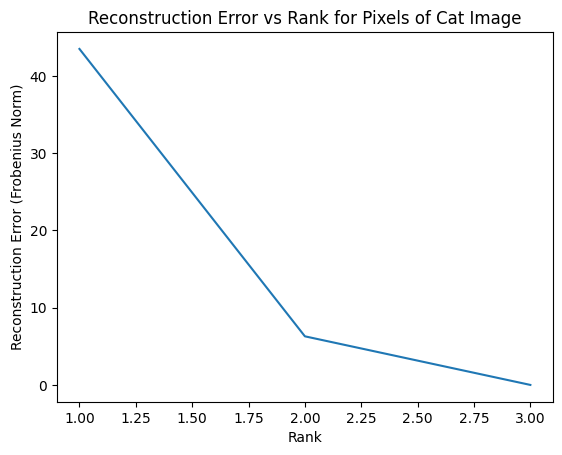

In [12]:
from src.matmul import svd
import torch
import matplotlib.image
# Pixels of a cute cat
A = torch.from_numpy(matplotlib.image.imread("data/cat.png")).view(-1, 3)

max_rank = min(A.shape)
rank_values, errors = compute_errors(A, max_rank)
plot_error_vs_rank(rank_values, errors, task = 'Pixels of Cat Image')

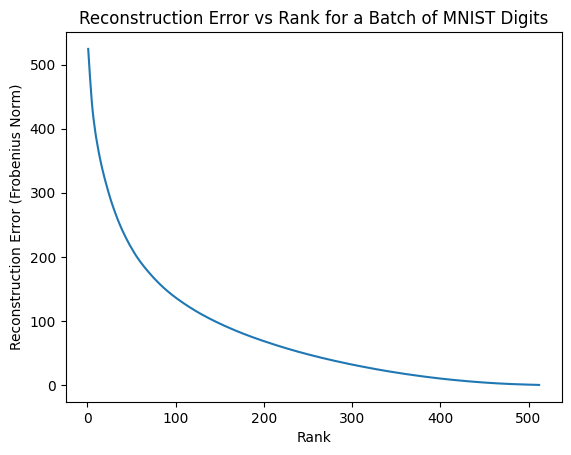

In [13]:
# A batch of MNIST digit
import torch
A = torch.load("data/mnist_act.pt")['act.0']

max_rank = min(A.shape)
rank_values, errors = compute_errors(A, max_rank)
plot_error_vs_rank(rank_values, errors, task = 'a Batch of MNIST Digits')

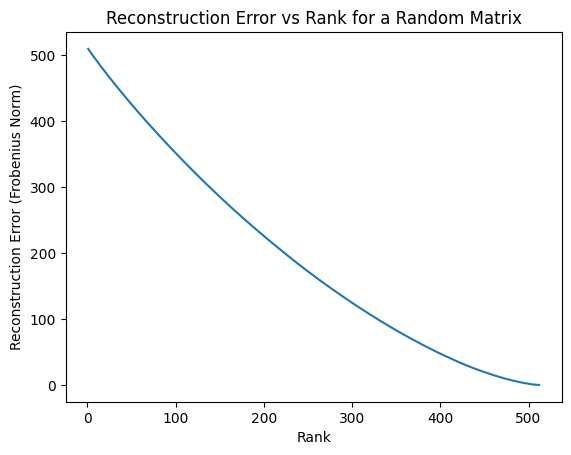

In [14]:
import torch
# A random matrix
A = torch.randn(512, 512)

max_rank = min(A.shape)
rank_values, errors = compute_errors(A, max_rank)
plot_error_vs_rank(rank_values, errors, task = 'a Random Matrix')

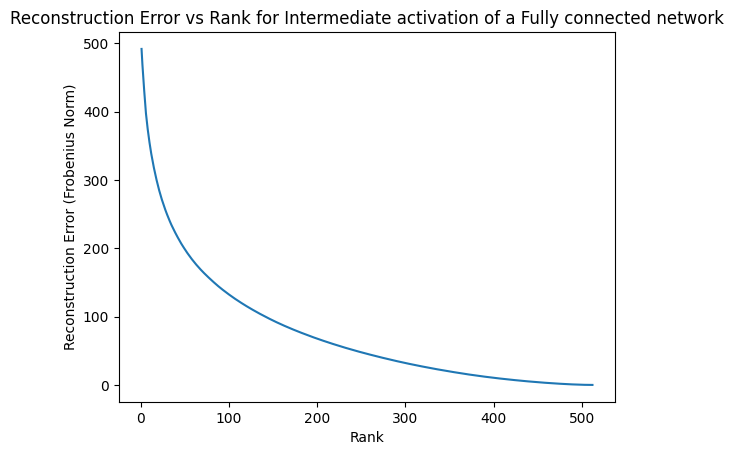

In [15]:
import torch
# Intermediate activation of a Fully connected network (trained on MNIST)
A = torch.load("data/mnist_act.pt")['act.1']

max_rank = min(A.shape)
rank_values, errors = compute_errors(A, max_rank)
plot_error_vs_rank(rank_values, errors, task = 'Intermediate activation of a Fully connected network')

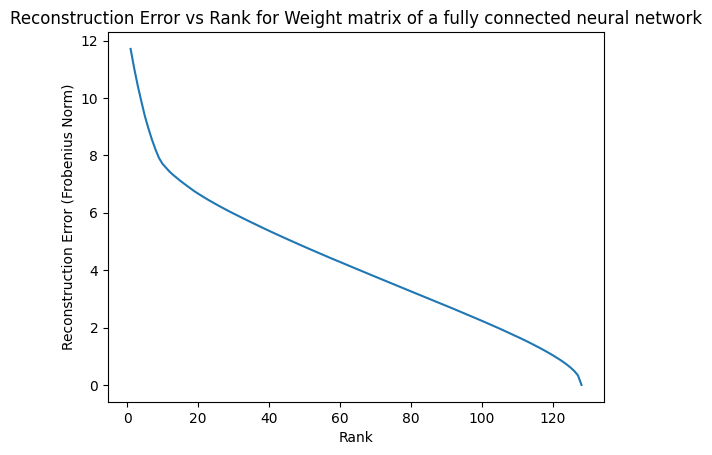

In [16]:
import torch
# Weight matrix of a fully connected neural network (trained on MNIST)
A = torch.load("data/mnist_fc.pt")['fc2.weight']

max_rank = min(A.shape)
rank_values, errors = compute_errors(A, max_rank)
plot_error_vs_rank(rank_values, errors, task = 'Weight matrix of a fully connected neural network')

# 2. Rank v.s. Speed up

In this following cell(s), please plot the number of ranks preserved for A matrix (in the x-axis)
and the speed up of matrix-matrix multiply (in the y-axis, measured by both FLOPs and clock time)

You can assume both matrix A and B are using the same number of rank when approximating.

In [8]:
import torch
# Intermediate activation of a Fully connected network (trained on MNIST)
A = torch.load("data/mnist_act.pt")['act.1']

# Weight matrix of a fully connected neural network (trained on MNIST)
B = torch.load("data/mnist_fc.pt")['fc2.weight'].transpose(0, 1)


In [9]:
import time
import matplotlib.pyplot as plt
from src.matmul import svd

In [10]:
# device = 'cuda'
device = 'cpu'

In [11]:
def matmul_time(A, B):
    start = time.time()
    torch.matmul(A, B)
    end = time.time()
    return end - start

In [12]:
def calc_svd_flops(A, B, rank):
    return (A.shape[0] * rank * A.shape[1]) + (B.shape[0] * rank * B.shape[1])

In [23]:
def rank_vs_speedup(A, B, max_rank):
    ranks = list(range(1, max_rank + 1))
    A = A.to(device)
    B = B.to(device)
    time_speedup = []
    flops_speedup = []

    # Calculate original runtime and FLOPS
    original_runtime = matmul_time(A, B)
    original_flops = A.shape[0] * A.shape[1] * B.shape[1]

    for rank in ranks:
        # Perform SVD approximation
        svd_start_time = time.time()
        AB_approx = svd(A, B, rank_A=rank, rank_B=rank)
        svd_end_time = time.time()

        # Calculate runtime and FLOPS for the approximation
        # runtime_approx = matmul_time(A, AB_approx)
        runtime_approx = svd_end_time - svd_start_time
        flops_approx = calc_svd_flops(A, B, rank)

        # Calculate speedup metrics
        time_speedup.append(original_runtime / runtime_approx)
        flops_speedup.append(original_flops / flops_approx)

        torch.cuda.empty_cache()

    return ranks, time_speedup, flops_speedup

In [14]:
def plot_runtime_speedup(ranks, time_speedup):

    fig, ax = plt.subplots()

    color = 'tab:blue'
    ax.set_xlabel('Ranks')
    ax.set_ylabel('Runtime Speedup', color=color)
    ax.plot(ranks, time_speedup, color=color)
    ax.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Rank vs Runtime Speedup')
    plt.show()

In [15]:
# def plot_flops_speedup(ranks, flops_speedup):

#     fig, ax = plt.subplots()

#     color = 'tab:red'
#     ax.set_xlabel('Ranks')
#     ax.set_ylabel('FLOPS Speedup', color=color)
#     ax.plot(ranks, flops_speedup, color=color)
#     ax.tick_params(axis='y', labelcolor=color)

#     fig.tight_layout()
#     plt.title('Rank vs FLOPS Speedup')
#     plt.show()

In [16]:
def plot_flops_speedup(ranks, flops_speedup):
    fig, ax = plt.subplots()

    color = 'tab:red'
    ax.set_xlabel('Ranks')
    ax.set_ylabel('FLOPS Speedup', color=color)
    ax.plot(ranks, flops_speedup, color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_yscale('log')  # Set log scale for y-axis

    fig.tight_layout()
    plt.title('Rank vs FLOPS Speedup')
    plt.show()


In [18]:
max_rank = min(A.shape[1], B.shape[0])

In [25]:
ranks, time_speedup, flops_speedup = rank_vs_speedup(A, B, max_rank)

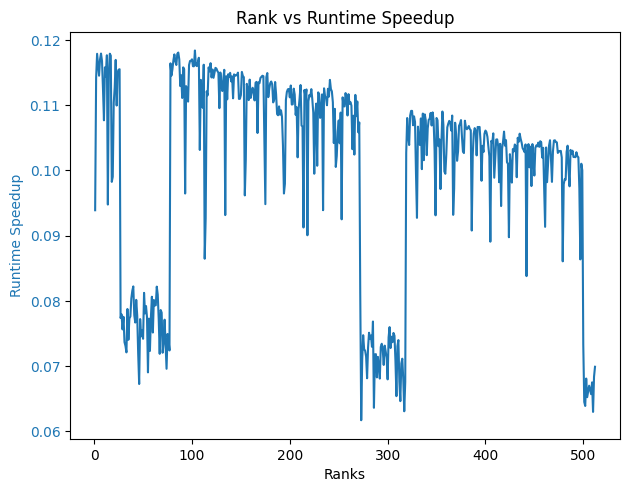

In [26]:
plot_runtime_speedup(ranks, time_speedup)

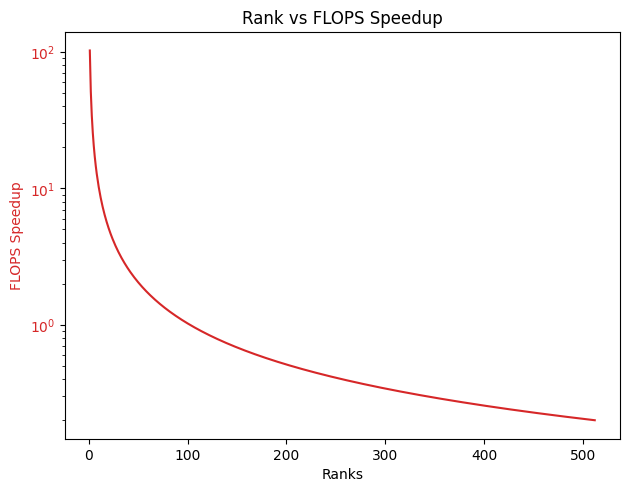

In [27]:
plot_flops_speedup(ranks, flops_speedup)

# 3. MNIST Training

In [45]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

# %mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
# !git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a4-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}"

/content/gdrive/MyDrive/ece5545
/content/gdrive/MyDrive/ece5545/a4-anya-23-ct
M	1-numerical_precision.ipynb
M	2-svd_rank.ipynb
M	fix_workflow.diff
Already on 'main'
Your branch is up to date with 'origin/main'.
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), 294 bytes | 7.00 KiB/s, done.
From https://github.com/ML-HW-SYS/a4-anya-23-ct
   fd8d87c..1d4a4ae  main       -> origin/main
Updating fd8d87c..1d4a4ae
Fast-forward
 mnist.py | 6 +++++-
 1 file changed, 5 insertions(+), 1 deletion(-)
/content/gdrive/MyDrive/ece5545


In [46]:
%cd {PROJECT_ROOT}

/content/gdrive/MyDrive/ece5545/a4-anya-23-ct


In [47]:
!python mnist.py

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324591
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.946798
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.924738
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.479755
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.545340
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.344036
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.194653
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.343248
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.533786
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.228848
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.203924
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.316749
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.390759
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.162607
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.225830
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.081305
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.212428
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.162631
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.472853
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.161051
Train Epoch: 1 [12800/60000 (

In [48]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle

with open('low_rank_data.pickle', 'rb') as f:
  compress_ratios, accuracies, runtimes = pickle.load(f)

print(compress_ratios)
print(accuracies)
print(runtimes)

[3.9331536388140163, 3.6208436724565756, 3.35448275862069, 3.124625267665953, 2.9149021174590493, 2.7397671798723247, 2.5844845908607863, 2.445859872611465, 2.315455410980641, 2.2035638779824827, 2.101987899740709, 2.009363811622143, 1.9205053961568834, 1.8428896185905532, 1.771303714493809, 1.7050712783360598, 1.6406566224420958, 1.5836770132407207, 1.5305223410950284, 1.4808199715851431, 1.431992149165849, 1.3883920076117984, 1.3473684210526315, 1.3086995515695068, 1.2704161588020197, 1.2359817042181942, 1.2033646709549728, 1.172424875461996, 1.141605382569238, 1.1137230957105786, 1.0871703173893608, 1.0618541696987338, 1.0365108680210258, 1.0134740936241144, 0.9914390542193233, 0.9703418007713792, 0.9491349030831273, 0.9297820823244553, 0.9112026976395654, 0.8933512917840088, 0.8753449310137973, 0.8588581518540318, 0.8429809358752166, 0.827680090754396, 0.8122008237782478, 0.7979875314448212, 0.7842631409222831, 0.7710028532177956, 0.7575537327380334, 0.745174139515882, 0.7331926439

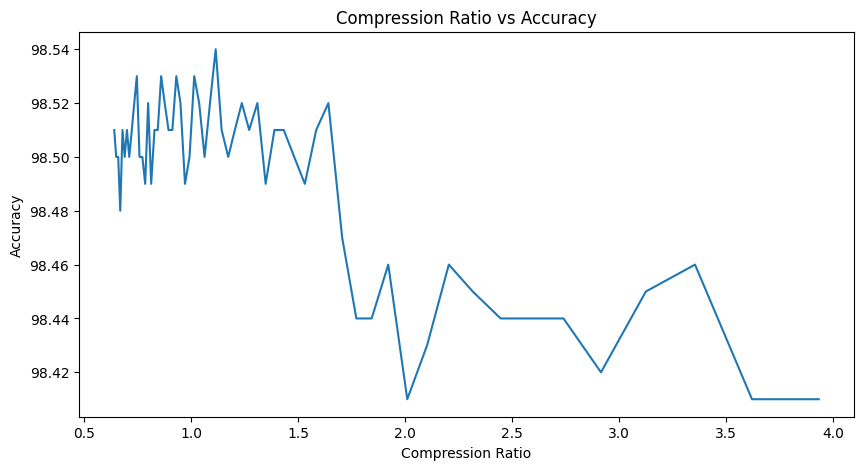

In [49]:
fig = plt.figure(figsize=(10,5))
plt.plot(compress_ratios, accuracies)
plt.xlabel('Compression Ratio')
plt.ylabel('Accuracy')
plt.title('Compression Ratio vs Accuracy')
fig.savefig('compression_ratio_vs_acc.png')
plt.show()

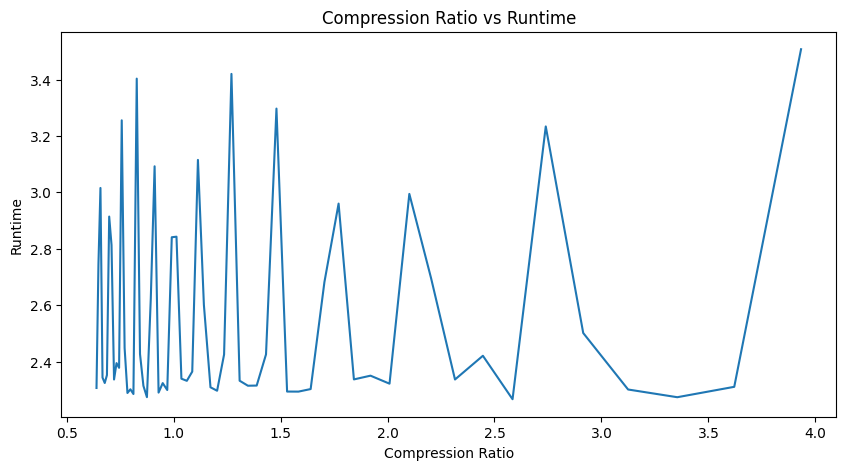

In [50]:
fig = plt.figure(figsize=(10,5))
plt.plot(compress_ratios, runtimes)
plt.xlabel('Compression Ratio')
plt.ylabel('Runtime')
plt.title('Compression Ratio vs Runtime')
fig.savefig('compression_ratio_vs_runtime.png')
plt.show()

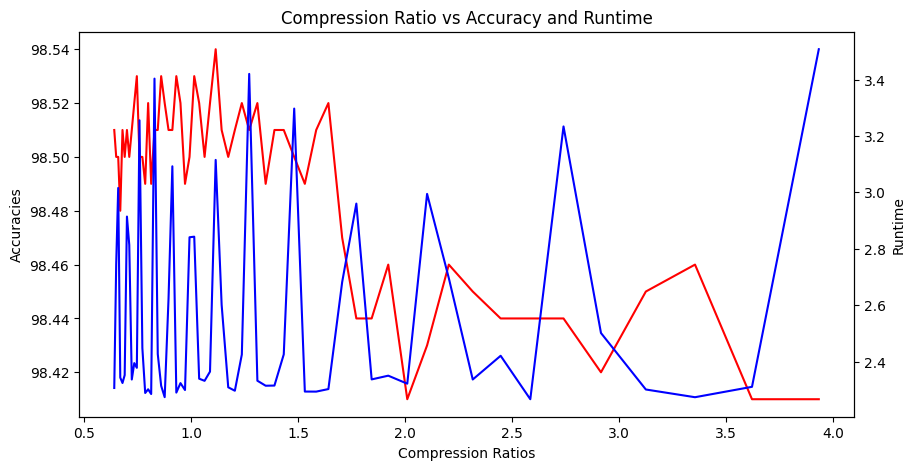

In [51]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(compress_ratios, accuracies, 'r')
ax.set_xlabel('Compression Ratios')
ax.set_ylabel('Accuracies')

ax2 = ax.twinx()
ax2.plot(compress_ratios, runtimes, 'b')
ax2.set_ylabel('Runtime')
plt.title('Compression Ratio vs Accuracy and Runtime')
fig.savefig('compression_ratio_vs_acc_and_runtime.png')
plt.show()